## Sentiment analysis with few plots for the EDA

### Importing Libraries

In [50]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

### Reading the dataset from scraping.ipynb

In [12]:
df = pd.read_csv('data.csv', dtype={'Title':'str', 'Body':'str', 'Stars':'int64'})

In [13]:
df.head()

,Title,Body,Stars
0,ne puoi fare a meno fin quando non lo provi,spedizione amazon sulle spedizione è una gar...,5
1,ottimo ma,allora non si capisce perché la versione con o...,5
2,qualità audio ottima ma attenzione a disattiv...,l echo dot è un dispositivo interessante ma h...,4
3,la domotica alla portata di tutti,spedizione rapidissima come da tradizione am...,5
4,echo dot un assistente virtuale di qualità ...,ho acquistato l echo dot e devo dire che son...,5


### Removing Stopwords

The stopwords are words that are filtered out before, or after, the actual words in the text that carry the information. In fact, most stop words have no particular meaning when isolated from the text. 

For the further modelling I still included the stopwords since sometimes they remove some context in the phrase.

In [14]:
list_title = df['Title'].to_list()
stopwords = nltk.corpus.stopwords.words('italian')
words_title = [word for text in list_title for word in nltk.word_tokenize(text)]
words_title_clear = [w for w in words_title if w not in stopwords]

### Most common words in titles and bodies

The function FreqDist creates a dictionary as per key the word and as value the number of times that word accurs in the text

In [15]:
fd_title = nltk.FreqDist(words_title_clear)

sorted_fd_title = dict(sorted(fd_title.items(), key=lambda item: item[1], reverse=True)) # sorting the dictionary based on the key (number of occurences per word)

/var/folders/qg/gd9h1fz150q_s3t9_v7l4qd80000gn/T/ipykernel_1479/1373915822.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Categories', y='Values', data=df_freq_title, palette='Set2')


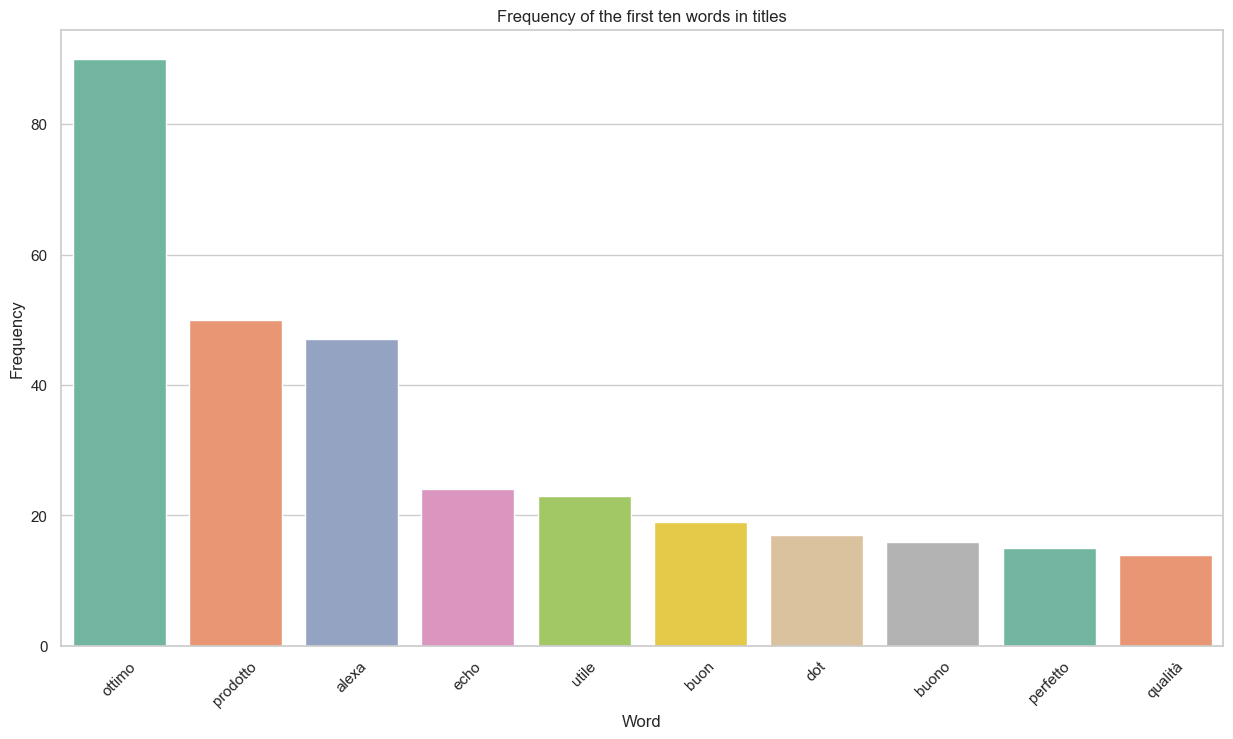

In [22]:
df_freq_title = pd.DataFrame(list(sorted_fd_title.items())[:10], columns=['Categories', 'Values'])

sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
ax = sns.barplot(x='Categories', y='Values', data=df_freq_title, palette='Set2')

ax.set(xlabel='Word', ylabel='Frequency', title='Frequency of the first ten words in titles')
plt.xticks(rotation=45)

plt.show()

In [23]:
list_body = df['Body'].to_list()
list_body = [str(word) for word in list_body]
words_body = [word for text in list_body for word in nltk.word_tokenize(text)]
words_body_clear = [w for w in words_body if w.lower() not in stopwords]

In [24]:
fd_body = nltk.FreqDist(words_body_clear)

sorted_fd_body = dict(sorted(fd_body.items(), key=lambda item: item[1], reverse=True))

/var/folders/qg/gd9h1fz150q_s3t9_v7l4qd80000gn/T/ipykernel_1479/4033434615.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Categories', y='Values', data=df_freq_body, palette='Set2')


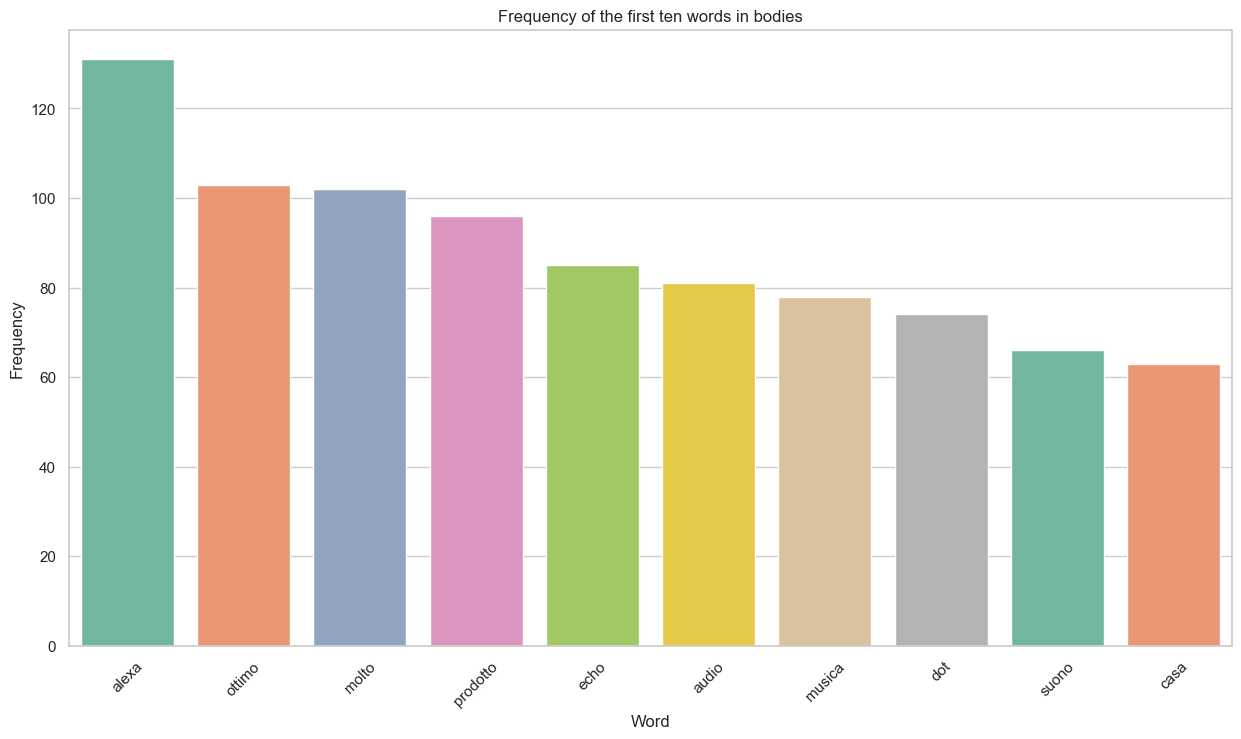

In [25]:
df_freq_body = pd.DataFrame(list(sorted_fd_body.items())[:10], columns=['Categories', 'Values'])

sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
ax = sns.barplot(x='Categories', y='Values', data=df_freq_body, palette='Set2')

ax.set(xlabel='Word', ylabel='Frequency', title='Frequency of the first ten words in bodies')
plt.xticks(rotation=45)

plt.show()

### How stars are subdivided?

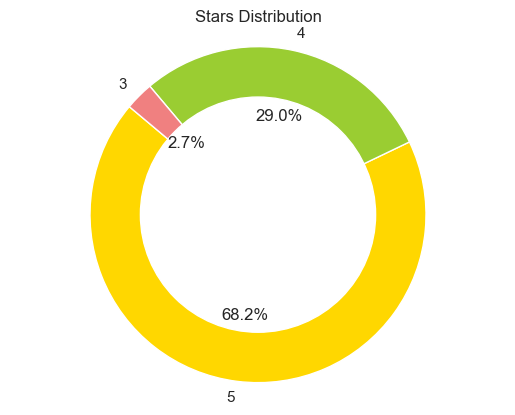

In [36]:
stars = df['Stars'].value_counts()
colors = ['gold', 'yellowgreen', 'lightcoral']

fig, ax = plt.subplots()
ax.pie(stars.iloc[:], labels=list(stars.index), colors=colors, autopct='%1.1f%%', startangle=140)

# Draw a white circle in the center to create a donut chart
circle = plt.Circle((0, 0), 0.7, color='white')
ax.add_artist(circle)

# Equal aspect ratio ensures that the pie chart is circular
ax.axis('equal')

# Add a title
plt.title('Stars Distribution')

# Show the plot
plt.show()

In [63]:
df['Body'].fillna('', inplace=True)

In [64]:
df['Full Review'] = df.apply(lambda row: (row['Title'] + ' ' + row['Body']), axis=1) # joining titles and bodies in orderto get a full text 

### Lemmatization

In [79]:
lemm = WordNetLemmatizer()

In [96]:
words = [nltk.word_tokenize(element, language='italian') for element in df['Full Review']]

In [97]:
lemmmatized_words = [lemm.lemmatize(word) for sublist in words for word in sublist]

In [98]:
df['Lemmatized Full Review'] = lemmmatized_words

ValueError: Length of values (15628) does not match length of index (510)

In [95]:
df['Lemmatized Full Review']

0      ne puoi fare a meno fin quando non lo provi sp...
1      ne puoi fare a meno fin quando non lo provi sp...
2      ne puoi fare a meno fin quando non lo provi sp...
3      ne puoi fare a meno fin quando non lo provi sp...
4      ne puoi fare a meno fin quando non lo provi sp...
                             ...                        
505    ne puoi fare a meno fin quando non lo provi sp...
506    ne puoi fare a meno fin quando non lo provi sp...
507    ne puoi fare a meno fin quando non lo provi sp...
508    ne puoi fare a meno fin quando non lo provi sp...
509    ne puoi fare a meno fin quando non lo provi sp...
Name: Lemmatized Full Review, Length: 510, dtype: object

### Review classification

Here I calculate the polarity of every review. 

To do that I used the function polarity_scores() that returns me a dictionary composed of the negative, neutral, positive and compound polarity of the text I gaver as input.

In [71]:
sia = SentimentIntensityAnalyzer()
text_polarity = [sia.polarity_scores(str(element)) for element in df['Full Review']]

Here I choose the polarity through the compound value, since it is the most consistent. When the compund value is 0.0 it means that the text is fully neutral, so I give as score 0.5

In [72]:
text_pol_mean = []

for i in range(len(text_polarity)):
    if text_polarity[i]['compound'] == 0.0:
        text_pol_mean.append(0.5)
    else:
        text_pol_mean.append(text_polarity[i]['compound'])

In [70]:
df['Polarity Full'] = text_pol_mean

I assigned a keyword to every review according to the value of the polarity

In [73]:
list_polarity = []
for i in range(len(df)):
    if df['Polarity Full'][i] < 0:
        list_polarity.append('Bad')
    elif df['Polarity Full'][i] <= 0.15:
        list_polarity.append('Neutral')
    else:
        list_polarity.append('Good')

df['Polarity_Text'] = list_polarity

In [74]:
df['Polarity_Text'].value_counts()

Polarity_Text
Good       428
Bad         71
Neutral     11
Name: count, dtype: int64

In [75]:
df.dtypes

Title             object
Body              object
Stars              int64
Polarity         float64
Polarity_Text     object
Full Review       object
Polarity Full    float64
dtype: object

Here I joined the titles and the bodies to get a full review since I used both to calculate the polarity and also because for further processing I will need the full text

In [76]:
df.sample(10)

,Title,Body,Stars,Polarity,Polarity_Text,Full Review,Polarity Full
376,comoda,facile da usare,5,0.250,Good,comoda facile da usare,0.500
369,musica di qualità con prezzo irrisorio,prodotto eccellente per dimensioni e sound,5,0.250,Good,musica di qualità con prezzo irrisorio prodott...,0.500
156,miglioramenti solamente nel design,rispetto al modello precedente di eco dot que...,5,0.250,Good,miglioramenti solamente nel design rispetto al...,0.500
249,soddisfatto buon prodotto,prodotto che oramai si recensisce da solo ess...,4,0.250,Good,soddisfatto buon prodotto prodotto che orama...,0.500
19,ottimo affare,acquistato in sconto insieme a ring intercom ...,5,0.186,Good,ottimo affare acquistato in sconto insieme a r...,0.340
246,un buon prodotto per la sua fascia di prezzo,la qualità dell audio non è male ma si potrebb...,4,0.186,Good,un buon prodotto per la sua fascia di prezzo l...,0.340
93,ottimo,ottimo,5,0.250,Good,ottimo ottimo,0.500
6,mi ha conquistato,l ho acquistato così un po per curiosità ma...,5,-0.189,Bad,mi ha conquistato l ho acquistato così un po...,-0.296
341,buono,mi sembrava più grosso dalla foto del resto f...,4,0.250,Good,buono mi sembrava più grosso dalla foto del r...,0.500
472,una sicurezza,possiedo già altri echo dot generazione ...,5,0.250,Good,una sicurezza possiedo già altri echo dot ...,0.500


## Dense Matrix to feed the models

Since the standard one with all the words could not be admissible since Machine Learning Models doesn't know how to interpret a certain word in order to classify a phrase, I needed to map every review according to the word it has in it.

To do so there is a particular module of sklearn.feature_extraction.text, **TfidfVectorizer** that allows us to create a dense matrix in order to see for every word a level of beloging to every review.

To calculate that level of belonging the module uses a formula:
$$
W_{x,y} = tf_{x,y} * \log{\frac{N}{df_x}}
$$

Where:
1. $ W_{x,y} $ is word x within review y;
2. $tf_{x,y}$ is the frequency of x in y;
3. $df_x$ is the number of review containing x;
4. $N$ is the total number of reviews

In [11]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Full Review'])
feature_names = vectorizer.get_feature_names_out()
matrix = vectors.todense()
list_dense = matrix.tolist()
sparse_matrix = pd.DataFrame(list_dense, columns=feature_names)

Doing that I can assign to every row of the matrix containing all the reviews the same value of polarity, since the order is still the same 

In [12]:
sparse_matrix['Polarity_Text'] = list_polarity

In [15]:
sparse_matrix.sample(10)

,abbassare,abbasso,abbastanza,abbia,abbiamo,abbiano,abbina,abbinabili,abbinamento,abbinandolo,...,vuole,web,wi,wifi,wireless,wow,xd,youtube,zio,Polarity_Text
370,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
71,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
147,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bad
17,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
387,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
126,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
502,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
85,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
382,0.0,0.0,0.0,0.0,0.134127,0.119918,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
181,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good


### Writing dataframe and sparse matrix into two files

In [24]:
df.to_csv('data_final.csv', index=False)

In [25]:
sparse_matrix.to_csv('matrix.csv', index=False)